# Elwah River Offset Arial Photo Matching

## Introduction

The purpose of this project is to prepare RGB and IR images taken of the Elwah river in 2012 for more advanced CV processing like cold water refuge mapping. The dataset is made up of photos taken by an IR camera and an RGB camera. As such, the RGB images and IR images do not align. There is an additional quirk adding complexity: the RGB images overlap, as do the IR images.

The goal of this project is to develop a process for matching images taken from slightly different camera angles. We will be accomplishing that in this case by stitching together RGB images via feature detection, like a panorama. Then, these stitched images will be transformed and sliced to match their corresponding IR, which will be identified via special feature detection. The final product should be a dataset of unmodified IR images and their corresponding reconstructed RGB matches.

## Getting Started

In [1]:
import numpy as np
import os.path
import scipy.io
import cv2
from PIL import Image as im
import matplotlib.pyplot as plt
import stitching
import util

In [2]:
# We only use this running locally, since this data file is too big for Github.
airborne_data_path = "../data/AirborneData.mat"
# This allows the code to be runnable on Binder or Colab
# airborne_data_path = "../data/AirborneDataMini.mat"

# These files are smaller so we don't have to worry about them.
surfacetemp_data_path = "../data/SurfaceIRtemp.dat"
meta_data_path = "../data/InsituData.dat"

assert os.path.exists(airborne_data_path)
assert os.path.exists(surfacetemp_data_path)
assert os.path.exists(meta_data_path)

Loading the massive `mat` file takes a while so we place it in its own code cell.

In [3]:
airborne_data = scipy.io.loadmat(airborne_data_path)

Let's take a look at the keys.

In [4]:
airborne_keys = list(airborne_data.keys())
print(airborne_keys)

['__header__', '__version__', '__globals__', 'imageRGB', 'imageIR', 'maskRiver', 'tempRiver', 'northings', 'eastings', 'Xt', 'Yt', 'Zt', 'altitude', 'datePDT']


Looks like we have our images under 'imageRGB' and 'imageIR'.
Examining the format will help us figure out how to use the data.

In [5]:
raw_images = airborne_data[airborne_keys[3]]
print(type(raw_images))
print(raw_images.shape)
num_images = raw_images.shape[2]

<class 'numpy.ndarray'>
(640, 480, 406, 3)


For some reason, the format the images are stored in seems to require us to index by the 3rd dimension.
The images are each 640x480 and 3 channel (RGB), and there are 406 in total.

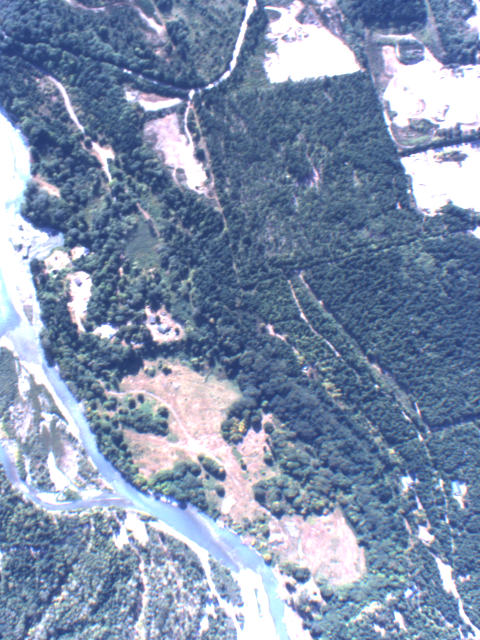

In [6]:
rgb_images = []
for x in range(num_images):
  image_data = im.fromarray(raw_images[:,:,x])
  rgb_images.append(image_data)
  image_data.save(f"../out/airborne_{x+1}.png")

display(rgb_images[10])

In [7]:
raw_ir_images = airborne_data[airborne_keys[4]]
print(type(raw_ir_images))
print(raw_ir_images.shape)

target_width = raw_ir_images.shape[0]
target_height = raw_ir_images.shape[1]

<class 'numpy.ndarray'>
(480, 640, 406)


Hmm... for some reason these images are sideways compared to the RGB ones. Also, pillow has trouble with this grayscale format so we are going to have to save images with matplotlib. We will store the dimensions for later, so we know what we are aiming for.

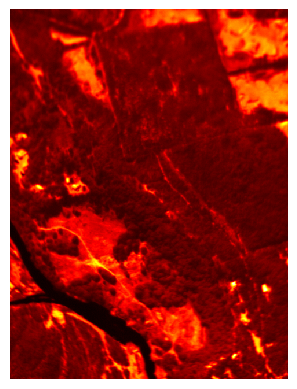

In [8]:
ir_images = []
for x in range(num_images):
  ir_image = np.rot90(raw_ir_images[:,:,x], -1, (0, 1))
  ir_images.append(ir_image)
  plt.imsave(f"../out/airborne_ir_{x+1}.png", ir_image, format="png", cmap="hot")

plt.imshow(ir_images[10], interpolation="none", cmap="hot")
plt.axis('off')
plt.show() # saved images won't look quite like this, as they won't have the white padding

## Stitching

The opencv image stitching pipeline is fairly complex. To simplify the process, we can use a python package based on opencv's stitching module, creatively called `stitching`.

The first step is to set up our stitcher object. Since we know that our dataset consists of terrain view from above, we want our stitches to remain as close to this as possible, that is, they should be as "flat" as possible. This immediately should indicate that the `mercator` and `transverseMercator` warpers are our best bet, and in fact some quick experimentation revealed transverseMercator to be the best for keeping the distortion in our panorama to a minimum.

In [9]:
settings = {"warper_type": "transverseMercator", "crop": False}
stitcher = stitching.Stitcher(**settings)

Stitching failed for the following images:
 [35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 57, 57, 58, 58, 59, 59, 60, 60, 61, 61, 62, 62, 63, 63, 64, 64, 65, 65, 66, 66, 67, 67, 68, 68, 69, 69, 70, 207, 208, 248, 249, 267, 268, 282, 283, 294, 295, 310, 311, 342, 343, 358, 359, 359, 360, 375, 376, 385, 386, 394, 395, 399, 400, 402, 403, 403, 404, 404, 405, 405, 406]
Resulting dataset loss: 25.62%


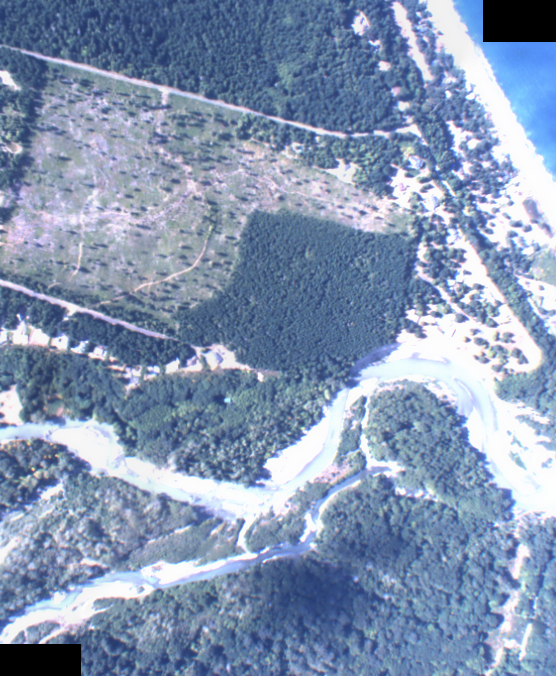

In [10]:
failed = []
for x in range(num_images - 1):
	
  try:
    stitched = stitcher.stitch([f"../out/airborne_{x+1}.png", f"../out/airborne_{x+2}.png"])
    cv2.imwrite(f"../out/stitch_{x+1}.png", stitched)
  except:
    failed.append(x+1)
    failed.append(x+2)

print(f"Stitching failed for the following images:\n", failed)
print(f"Resulting dataset loss: {util.percentage(failed, num_images)}%")
im.open("../out/stitch_1.png")

Stitching will fail for some number of the images. Unfortunately, if there aren't enough keypoints in the images there isn't much we can do. We will simply have to remove these images (and their associated IR images) from our dataset.

Although a loss of rougly `25%` may seem high, if we examine the images our stitching failed on, it seems a full `8%` aren't even images of the elwah river (#34 - #70) but rather images taken when the plane was turning around. Some of the later fails occur as the plane is descending and the image quality is poorer, as well as further inland where the area is more forested and there are less quality keypoints.

In [11]:
# Could avoid a dependency and just use opencv if only the documentation wasn't super vague about 
# how to change the warper used. I know the method, but not what to pass it.

# for x in range(num_images - 1):
# 	paths = [f"../out/airborne_{x+1}.png", f"../out/airborne_{x+2}.png"]
# 	images = []

# 	for path in paths:
# 		image = cv2.imread(path)
# 		images.append(image)

# 	stitcher = cv2.Stitcher_create()
#   # not a method?? stitcher.setWarper(cv2.TransverseMercatorWarper)
# 	(status, stitched) = stitcher.stitch(images)

# 	# status 0 indicates success
# 	if status == 0:
# 		cv2.imwrite(f"../out/stitch_{x+1}.png", stitched)
# 	else:
# 		print(f"stitching failed with status {status} for images {x+1} <-> {x+2}")

# im.open('../out/stitch_1.png')

Moving on, here we can see that the 2nd infrared image aligns with the first and second RGB images. Given that the misalignment factor between IR and RGB images is constant (they were attached to the same plane, just at different angles), this means for any IR image `x` we match it with RGB images `x` and `x - 1`. This means we can match every IR image fully with the exception of the first IR image.

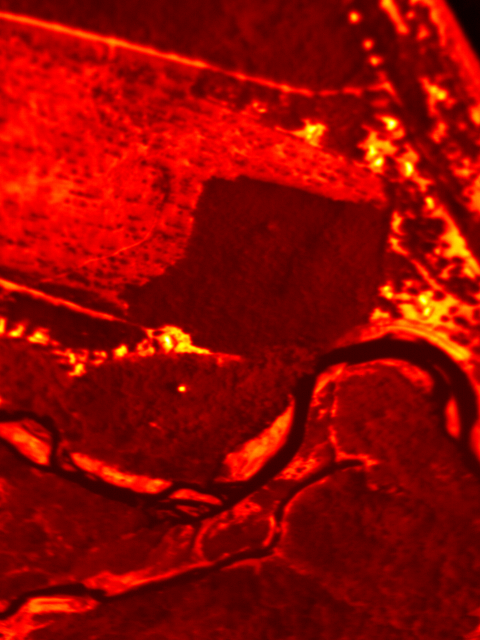

In [12]:
im.open("../out/airborne_ir_2.png")

## Matching

Now, we have to figure out what kind of descriptors we are going to use to figure out the alignment of the IR and RGB images. For a dataset where it is not as immediately obvious which images overlap with which and eyeballing it isn't going to cut it, the application of keypoints and descriptors could be used to match the images, but we will only be using them to figure out how to crop the stitched RGB images.

In [13]:
imrgb = cv2.imread('../out/stitch_1.png')[:,:,::-1] # opencv reads BGR so we use this notation to reverse the order
imir = cv2.imread('../out/airborne_ir_2.png', cv2.IMREAD_GRAYSCALE)

6607 RGB keypoints, 403 IR keypoints
263 matches found


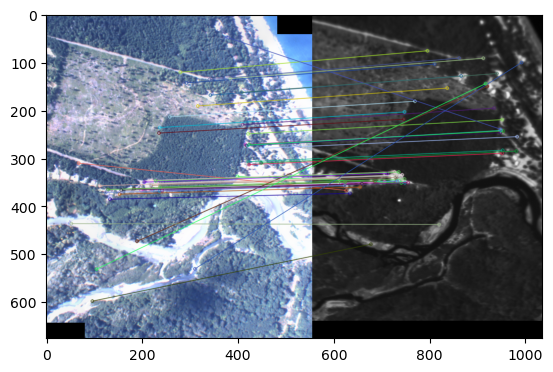

In [14]:
# Initiate BRISK detector
brisk = cv2.BRISK_create()

# find the keypoints and descriptors with BRISK, no mask
kp1, des1 = brisk.detectAndCompute(imrgb, None)
kp2, des2 = brisk.detectAndCompute(imir, None)
print(f"{len(kp1)} RGB keypoints, {len(kp2)} IR keypoints")

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)
print(len(matches), "matches found")

# Sort them in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)

vis = cv2.drawMatches(imrgb, kp1, imir, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(vis)
plt.show()

It seems ORB descriptors don't do a half bad job, however BRISK descriptors seem to very slightly outperform them here (ORB trial not shown). This makes sense as BRISK has lower variance in response to photometric changes like illumination compared to ORB, which excels at geometric changes. According to [this](https://arxiv.org/ftp/arxiv/papers/2012/2012.04135.pdf) paper however, KAZE and AKAZE should outperform BRISK for photometric changes. In fact, the paper claims KAZE and AKAZE are most invariant to photometric changes out of all opencv detectors and descriptors!

Granted, the paper is testing this via variance in response to illumination, blur, and compression. I was unable to find much in the literature with regards to which detectors and descriptors perform best in matching across colorspaces, as most techniques which tackle this problem use neural networks (2, 3). 

2276 RGB keypoints, 385 IR keypoints
211 matches found


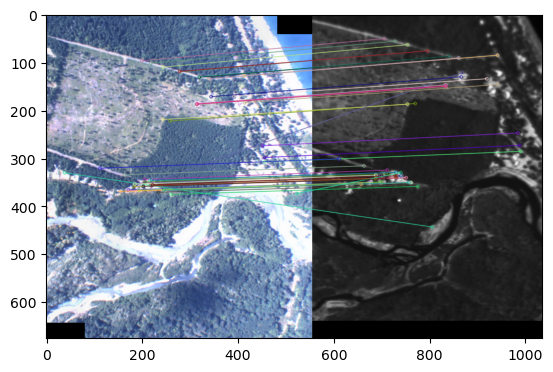

In [15]:
# Initiate AKAZE detector
akaze = cv2.AKAZE_create()

# find the keypoints and descriptors with BRISK
kp1, des1 = akaze.detectAndCompute(imrgb, None)
kp2, des2 = akaze.detectAndCompute(imir, None)
print(f"{len(kp1)} RGB keypoints, {len(kp2)} IR keypoints")

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)
print(len(matches), "matches found")

# Sort them in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)

vis = cv2.drawMatches(imrgb, kp1, imir, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(vis)
plt.show()

From this simple test, this seems to be the case, with AKAZE only having 2 erroneous matches in the top 50 best matches, compared to BRISK's 8 erroneous matches. 

We can do further corrections down the line however, as our knowledge of how the matches should look can allow us to filter out erroneous keypoints in a way that keypoint distance alone cannot. Specifically, we know something in the top right of the IR image probably shouldn't be matching with something in the bottom left of the RGB image. We will implement this further down the line.

In [16]:
def findAndMatchKeypoints(im_rgb, im_ir):
  # Initiate AKAZE detector, find the keypoints and descriptors with BRISK
  akaze = cv2.AKAZE_create()
  kp1, des1 = akaze.detectAndCompute(im_rgb, None)
  kp2, des2 = akaze.detectAndCompute(im_ir, None)

  # create BFMatcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

  # Match descriptors and sort by distance
  matches = bf.match(des1, des2)
  matches = sorted(matches, key = lambda x:x.distance)

  return kp1, kp2, matches

## Mapping

Its time for the meat of the alignment process, namely estimating the homographies that would map the IR images to the RGB stitches' coordinate spaces, and then using this projection to create a mask. However, before we get started we need to do some preparation.

The way `BFMatcher` works is that it returns to us a list of `cv2.DMatch` objects. Each of these objects has a `queryIdx` and `trainIdx` attribute. These correspond to the index in kp1 and kp2 which the match represents, respectively. Therefore we can obtain the image coordinates of the matches with the following code.

In [19]:
def compileMatchedCoords(keypoints1, keypoints2, matches):
  rgb_coords = []
  ir_coords = []

  for match in matches[:50]:
    rgb_kp_index = match.queryIdx
    ir_kp_index = match.trainIdx

    rgb_coords.append(keypoints1[rgb_kp_index].pt)
    ir_coords.append(keypoints2[ir_kp_index].pt)

  return (rgb_coords, ir_coords)

Recall our images are 640x480, lets take a look what our points look like by ploting the coordinates for the first 15 matches. It should match the matches we have up above in the previous step.

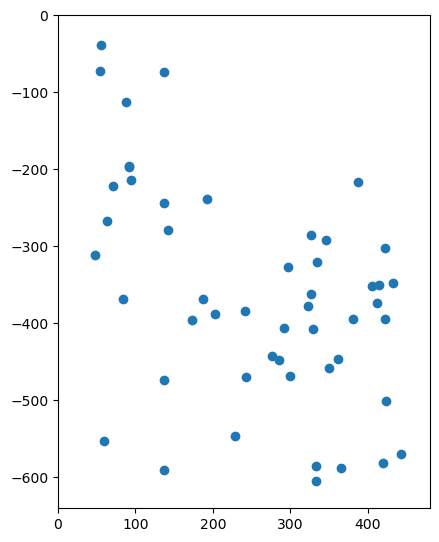

In [24]:
rgb_coords, ir_coords = compileMatchedCoords(kp1, kp2, matches)

x_val = [pt[0] for pt in ir_coords[:50]]
y_val = [-pt[1] for pt in ir_coords[:50]] # negative because img coords start 0,0 at the top left with +y going down

plt.figure(figsize=(4.8, 6.4))
plt.scatter(x_val, y_val)
plt.xlim([0, 480])
plt.ylim([-640, 0])
plt.show()

Great, it looks like that works. We now have the coordinates of the matched keypoints in order of match distance. Next, lets create a function that turns all black pixels transparent. This will be useful when masking portions of the stitched RGB images later.

In [20]:
def blackToTransparent(path, thresh=0):
  img = cv2.imread(path) # load as np array, BGR
  alpha = np.sum(img, axis=-1) > thresh # boolean mask of sum over BGR
  alpha = np.uint8(alpha * 255) # uint8 to make imread

  res = np.dstack((img, alpha))
  cv2.imwrite(path, res)

def colorInvert(path):
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED) # load as np array, BGR
  
  b, g, r, a = cv2.split(img)
  b = np.invert(b)
  g = np.invert(g)
  r = np.invert(r)
  inv = cv2.merge([b, g, r, a], 4)

  cv2.imwrite(path, inv)

This next part is the most informal part of the workflow, but is a useful step and one that is difficult to automate and abstract away. 

We need to run the code below to generate all of the matched images. Then, we need to go through the images by hand and select a baseline homography. This should be an image that is transformed and matched in a way that will be similar to much of the dataset. Finally, by looking through the input we need to select some appropriate thresholds. This can be done by searching through the images until a poor homography warping is found, and checking the difference from standard for all the (good) homographies before compared to the difference from standard for the poor homography.

This is a fairly subjective process, but in essence it can be done via trial and error, running the workflow with certain values and examining if there are any outputs that are very poor reconstructions. If there are, we need to examine the associated homography and bounds to re-evaluate our thresholds.

In [22]:
standard = np.array([
  [8.8e-01, -1.0e-03, 6.0e+01],
  [-1.0e-02, 8.8e-01, 5.5e+01],
  [-5.0e-05, 0.0, 1.0e+00],
])
homography_threshold = 150
shape_threshold = 0.75

def isOutlier(homography, img):
  bounds = img.getbbox()
  shape = img.size
  homography_distance = abs(np.sum(homography - standard))

  # Uncomment these to figure out good homography and bounds thresholds
  # print(homography_distance)
  # print(bounds)

  return (homography_distance > homography_threshold or 
    bounds[0] == 0 or bounds[1] == 0
    # bounds[2] < (shape_threshold * target_width)
    # bounds[3] < (shape_threshold * target_height)
  )


 1
(556, 676) 0.8224852071005917
(63, 51, 500, 627)
1.0860621527441308

 2
(571, 662) 0.8625377643504532
(67, 56, 500, 634)
15.171315790423769

 3
(561, 655) 0.8564885496183207
(63, 64, 502, 648)
23.38395477076119

 4
(559, 666) 0.8393393393393394
(63, 44, 504, 629)
4.065518652998853

 5
(573, 826) 0.6937046004842615
(58, 30, 505, 621)
1.021435798506046

 6
(655, 784) 0.8354591836734694
(67, 49, 534, 645)
34.98882684356093

 7
(654, 740) 0.8837837837837837
(62, 46, 541, 658)
39.27357745488429

 8
(667, 691) 0.9652677279305355
(66, 60, 549, 672)
57.57396228671159

 9
(632, 716) 0.88268156424581
(73, 85, 552, 693)
98.23148720491831

 10
(627, 671) 0.9344262295081968
(65, 51, 538, 652)
35.768645044030016

 11
(605, 687) 0.8806404657933042
(65, 70, 527, 670)
55.05297477870019

 12
(610, 675) 0.9037037037037037
(61, 62, 527, 662)
34.576837412451546

 13
(599, 674) 0.8887240356083086
(65, 56, 526, 650)
28.818006841668257

 14
(598, 678) 0.8820058997050148
(59, 46, 518, 634)
12.6980588423793

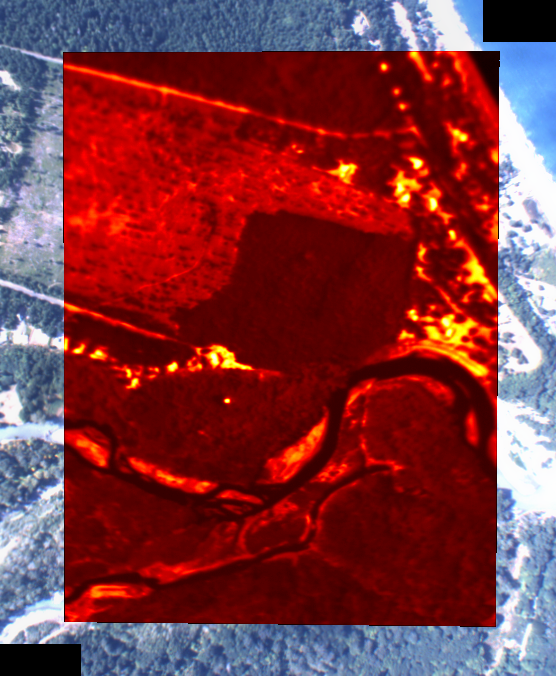

In [25]:
poor_quality = []
for x in range(num_images - 1):
  rgb_path = f"../out/stitch_{x+1}.png"
  ir_path = f"../out/airborne_ir_{x+2}.png"
  match_path = f"../out/match_{x+1}.png"

  if (not os.path.exists(rgb_path) or not os.path.exists(ir_path)):
    continue

  im_rgb = cv2.imread(rgb_path)[:,:,::-1] # opencv reads BGR so we use this notation to reverse the order
  im_ir = cv2.imread(ir_path, cv2.IMREAD_GRAYSCALE)

  # Get our keypoints matched and into a usable for for the homography
  kp1, kp2, matches = findAndMatchKeypoints(im_rgb, im_ir)
  rgb_coords, ir_coords = compileMatchedCoords(kp1, kp2, matches)

  homography, status = cv2.findHomography(np.array(ir_coords), np.array(rgb_coords), cv2.RANSAC, 7.5)

  # Warp source image to destination based on homography
  ir_warped = cv2.warpPerspective(im_ir, homography, (im_rgb.shape[1], im_rgb.shape[0]))

  # For some reason plt.imsave leaves some near black pixels around the edge, not
  # completely black, so we set a higher threshold. We want just the projected IR image.
  plt.imsave(match_path, ir_warped, format="png", cmap="hot")
  blackToTransparent(match_path, 10)

  # We then paste this projected IR image onto our stitched RGB image.
  im_rgb = im.open(rgb_path, "r")
  ir_overlay = im.open(match_path, "r")
  im_rgb.paste(ir_overlay, (0, 0), ir_overlay) # when pasting transparent image, 3rd parameter is mask (uses alpha channel)
  
  print("\n", x+1)
  print(ir_overlay.size, ir_overlay.size[0] / ir_overlay.size[1])
  print(ir_overlay.getbbox())
  print(abs(np.sum(homography - standard)))

  if (isOutlier(homography, ir_overlay)):
    # print(f"Outlier detected for match {x+1}, marking as poor...")
    poor_quality.append(x)

  im_rgb.save(match_path)
  
print(f"Poor matches found for the following images:\n", poor_quality)
im.open('../out/match_1.png')

Now, we need to repeat essentially the same workflow as above, except instead of projecting and pasting the IR image onto the RGB stitch, we want to use the same homograph but project and paste a mask onto a background, in order to generate a mask that can later be pasted onto the RGB stitch in order to crop it.

The mask should have the size of the IR image, and the background that of the RGB image.

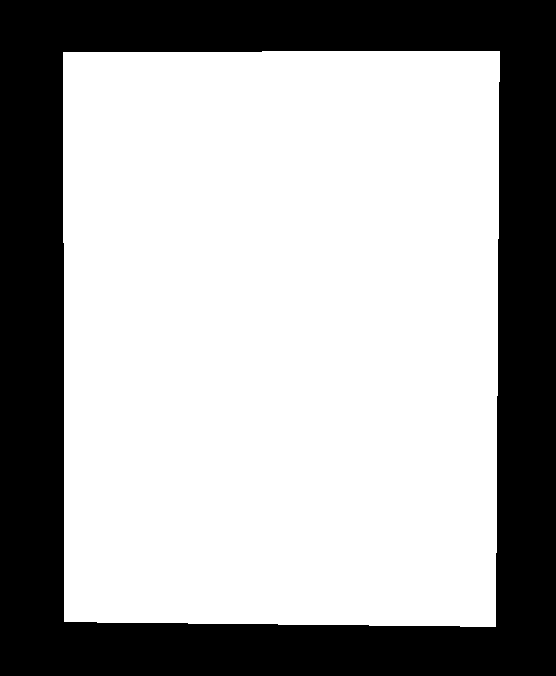

In [33]:
for x in range(num_images - 1):
  rgb_path = f"../out/stitch_{x+1}.png"
  ir_path = f"../out/airborne_ir_{x+2}.png"

  if (not os.path.exists(rgb_path) or not os.path.exists(ir_path)):
    continue

  im_rgb = cv2.imread(rgb_path)[:,:,::-1] # opencv reads BGR so we use this notation to reverse the order
  im_ir = cv2.imread(ir_path, cv2.IMREAD_GRAYSCALE)

  kp1, kp2, matches = findAndMatchKeypoints(im_rgb, im_ir)
  rgb_coords, ir_coords = compileMatchedCoords(kp1, kp2, matches)
  homography, status = cv2.findHomography(np.array(ir_coords), np.array(rgb_coords), cv2.RANSAC, 7.5)

  # Warp source image to destination based on homography
  mask = np.ones((im_ir.shape[0], im_ir.shape[1], 3), np.uint8) * 255
  mask_warped = cv2.warpPerspective(mask, homography, (im_rgb.shape[1], im_rgb.shape[0]))

  # we currently have a white rectange projected onto a black background. We need
  # to invert this so we can cut out the rectangle using blackToTransparent.
  plt.imsave(f"../out/mask_{x+1}.png", mask_warped, format="png")
  colorInvert(f"../out/mask_{x+1}.png")

  # Because of the rotation, some edge pixels are between black and white, we can just 
  # remove all of these, so we treat any non-fully white pixel as black. 255*3 - 1 = 764
  blackToTransparent(f"../out/mask_{x+1}.png", 764)
  colorInvert(f"../out/mask_{x+1}.png") # One final color invert since we always cut black pixels
  
im.open('../out/mask_1.png')

With all our masks prepared, the final remaining step is to create a method that can extract our masked RGB data. We need to find our keypoints and homography again, this time so that we can project in the reverse direction. Then, once we cut away all the black pixels we can use the `getbbox` method to crop and resize such that only non-transparent pixels are left.

![Masking Workflow](../img/masking.png)

In [42]:
def cropFromAdvancedMask():
  rgb_path = f"../out/stitch_{x+1}.png"
  mask_path = f"../out/mask_{x+1}.png"
  ir_path = f"../out/airborne_ir_{x+2}.png"

  if (not os.path.exists(rgb_path) or not os.path.exists(mask_path) or not os.path.exists(ir_path)):
    return False

  np_rgb = cv2.imread(rgb_path)[:,:,::-1]
  im_ir = cv2.imread(ir_path, cv2.IMREAD_GRAYSCALE)
  im_rgb = im.open(rgb_path, "r")
  mask = im.open(mask_path, "r")

  kp1, kp2, matches = findAndMatchKeypoints(np_rgb, im_ir)
  rgb_coords, ir_coords = compileMatchedCoords(kp1, kp2, matches)
  homography, status = cv2.findHomography(np.array(ir_coords), np.array(rgb_coords), cv2.RANSAC, 7.5)
  inv_homography = np.linalg.inv(homography)

  im_rgb.paste(mask, (0, 0), mask) # when pasting transparent image, 3rd parameter is mask (uses alpha channel)
  im_rgb.save(f"../out/cropped_{x+1}.png")

  img = cv2.imread(f"../out/cropped_{x+1}.png")
  img = cv2.warpPerspective(img, inv_homography, (np_rgb.shape[1], np_rgb.shape[0]))
  cv2.imwrite(f"../out/cropped_{x+1}.png", img)

  blackToTransparent(f"../out/cropped_{x+1}.png")

  # At this point, we should have the aligned section of the RGB image 
  # surrounded by transparent pixels, and it may be stretched or squeezed
  uncropped = im.open(f"../out/cropped_{x+1}.png")
  cropped = uncropped.crop(uncropped.getbbox())
  cropped = cropped.resize((480, 640))
  cropped.save(f"../out/cropped_{x+1}.png")

  return True

Successfully realigned 25 images.
Loss from ignored poor quality matches: 26.11%


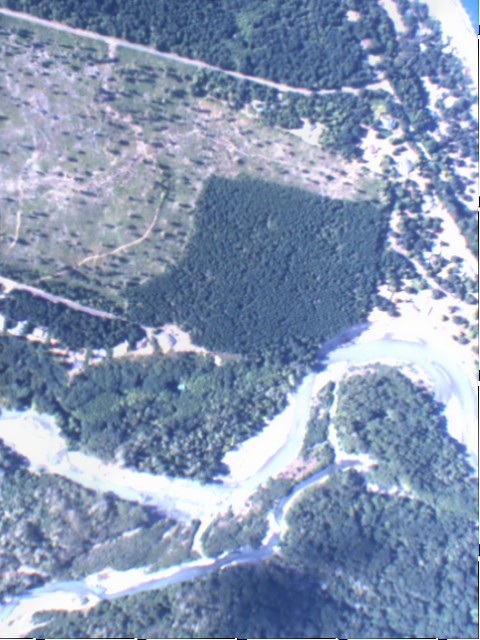

In [43]:
count = 0
for x in range(num_images - 1):
  if x not in poor_quality:
    cropFromAdvancedMask()
    count += 1
  
print(f"Successfully realigned {count} images.")
print(f"Loss from ignored poor quality matches: {util.percentage(poor_quality, num_images)}%")
im.open('../out/cropped_1.png')